In [1]:
# import packages
from sqlalchemy import create_engine
from sqlalchemy.orm import Session
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# connecting to db and defining session and connection parameters
engine = create_engine("sqlite:///hawaii.sqlite" , echo=False)
conn = engine.connect()
sess = Session(bind=engine)

In [3]:
# Import and establish Base for which classes will be constructed 
from sqlalchemy.ext.automap import automap_base
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()
## keys are just table names with type definitions

['measurement', 'station']

In [4]:
# Fetching class definition from automap_base
c_station = Base.classes.station
c_measurement = Base.classes.measurement

In [5]:
#loading data in dataframes
df_measurement = pd.read_sql("SELECT m.* FROM measurement m ", conn)
df_station = pd.read_sql("SELECT m.* FROM station m ", conn)

In [6]:
#setting dates for last year as data is upto certain date and not recent 
r = df_measurement['date'].max()
last_date = dt.date(int(r.split("-")[0]) , int(r.split("-")[1] ), int(r.split("-")[2]) )
last_year_ago = last_date - dt.timedelta(days=365)


In [7]:
#inspecting 
df_station.head(10)

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


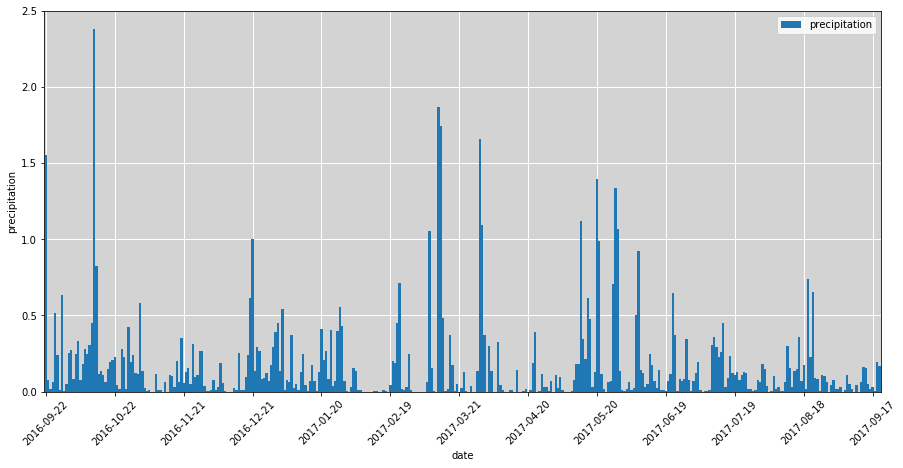

In [8]:
# Precipitation Analysis
# creating dataframe with date and prcp with date datatype 
# There can be mutiple data point for each date as all the station data is stored in same table
# Decided to use average 
list_measurement=[[
                   dt.date(int(r['date'].split("-")[0]) , int(r['date'].split("-")[1] ), int(r['date'].split("-")[2]) )
                   ,r['prcp'] 
                   , r['tobs']
                   , r['station']
                    ] 
                    for i,r in df_measurement.iterrows()  if 
                     (dt.date(int(r['date'].split("-")[0]) , int(r['date'].split("-")[1] ), int(r['date'].split("-")[2]) )
                     > last_year_ago) &
                    (dt.date(int(r['date'].split("-")[0]) , int(r['date'].split("-")[1] ), int(r['date'].split("-")[2]) )
                     < last_date)
                     #& ( r['station']== 'USC00519397')
                     ]

df_measurement_with_date = pd.DataFrame (list_measurement)
df_measurement_with_date.rename(columns={0 : 'date' , 1 : 'precipitation' , 2 : 'tobs', 3 : 'station' },inplace=True)
df_measurement_with_date=df_measurement_with_date.sort_values(['date'])

#-----aggregating average 
agg_dict_x = { 'precipitation': ['mean'] }
df_group_type = df_measurement_with_date.groupby(['date'])
df_measurement_with_date_stat = df_group_type.agg(agg_dict_x)
df_measurement_with_date_stat.columns = ["_".join(x) for x in df_measurement_with_date_stat.columns.ravel()]

df_measurement_with_date_stat.reset_index(inplace=True)
df_measurement_with_date_stat.rename(columns={'precipitation_mean' : 'precipitation'},inplace=True)
df_measurement_with_date_stat=df_measurement_with_date_stat.sort_values(['date'])


# using dateframe plot 

ax = df_measurement_with_date_stat.plot(kind="bar", x = 'date' , y = 'precipitation' ,width =1 , figsize=(15,7))
plt.ylabel("precipitation")

v_loc_value_list = []
v_date_value = last_year_ago
while v_date_value <  last_date:
    v_date_value = dt.timedelta(days=30) + v_date_value
    v_loc_value_list.append(v_date_value)

v_loc_list = [x for x in range(1,12,1) ]

plt.xticks(v_loc_list, v_loc_value_list)
ax.set_xticklabels(v_loc_value_list, rotation=45)
ax.set_facecolor('lightgray')
ax.xaxis.grid(color='white', linestyle='solid', linewidth=1)
ax.yaxis.grid(color='white', linestyle='solid', linewidth=1)
ax.set_axisbelow(True) # show plots on top of grid lines
ax.set_xticks(np.arange(0,365, 30)  )
plt.show()


In [9]:
#Use Pandas to print the summary statistics for the precipitation data. (for all the dates)

df_combine = pd.merge(df_station, df_measurement, on =['station','station']) 

agg_dict_x = { 'prcp': ['mean' , 'max' , 'min' ,'std',  'median'] }
df_group_type = df_combine.groupby(['name'])
df_precipitation_stat = df_group_type.agg(agg_dict_x)
df_precipitation_stat.columns = ["_".join(x) for x in df_precipitation_stat.columns.ravel()]

df_precipitation_stat.reset_index(inplace=True)
df_precipitation_stat.rename(columns={
    'prcp_mean' : 'precipitation_mean' ,
    'prcp_max' : 'precipitation_maximum_recorded', 
    'prcp_min' : 'precipitation_minimum_recorded', 
    'prcp_median' : 'precipitation_median', 
    'prcp_std' : 'precipitation_standard_deviation' 
    },inplace=True)
df_precipitation_stat

#It seems like MANOA LYON ARBO 785.2, HI US has most rain last year. Standard deviation still shows it as most rainy island.


,name,precipitation_mean,precipitation_maximum_recorded,precipitation_minimum_recorded,precipitation_standard_deviation,precipitation_median
0,"HONOLULU OBSERVATORY 702.2, HI US",0.047971,4.00,0.0,0.244826,0.00
1,"KANEOHE 838.1, HI US",0.141921,7.65,0.0,0.433905,0.02
2,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.121058,11.53,0.0,0.413812,0.02
3,"MANOA LYON ARBO 785.2, HI US",0.429988,8.06,0.0,0.712999,0.16
4,"PEARL CITY, HI US",0.063602,2.80,0.0,0.243931,0.00
5,"UPPER WAHIAWA 874.3, HI US",0.207222,6.30,0.0,0.508305,0.03
6,"WAIHEE 837.5, HI US",0.212352,9.64,0.0,0.543312,0.04
7,"WAIKIKI 717.2, HI US",0.049020,4.20,0.0,0.210583,0.00
8,"WAIMANALO EXPERIMENTAL FARM, HI US",0.114961,6.38,0.0,0.410237,0.00


In [10]:
# Station Analysis
# Design a query to calculate the total number of stations.
v_message = 'total number of stations.'
from sqlalchemy import func  
i = sess.query(c_station).count()
print(v_message)
print(i)

# List the stations and observation counts in descending order
v_message = 'List the stations and observation counts in descending order'
sel = [c_measurement.station, 
       func.count(c_measurement.tobs)]

v_result = sess.query(*sel).group_by(c_measurement.station).order_by(func.count(c_measurement.tobs).desc()) 

v_observatorycount_list = []
for r in v_result:
    (station, observation_counts) = r
    v_observatorycount_list.append((station, observation_counts))
print(v_message)   
print(v_observatorycount_list)  

# Which station has the highest number of observations?
v_message = 'station with the highest number of observations'
sel = [c_measurement.station, 
       func.count(c_measurement.station)]

v_result = sess.query(*sel).group_by(c_measurement.station).order_by(func.count(c_measurement.station).desc()).first()

v_most_active_station = v_result[0]
print(v_message)  
print(v_most_active_station)

# Design a query to retrieve the last 12 months of temperature observation data (tobs).
sel = [c_measurement.station, 
       func.max(c_measurement.date)]
v_result = sess.query(*sel).group_by(c_measurement.station).order_by(func.max(c_measurement.date).desc()).first()
last_date_str = v_result[1]
last_date = dt.date(int(last_date_str.split("-")[0]) , int(last_date_str.split("-")[1] ), int(last_date_str.split("-")[2]) )
last_year_ago = last_date - dt.timedelta(days=365)
last_year_ago_str = last_year_ago.strftime("%Y") +'-' +last_year_ago.strftime("%m")+'-' + last_year_ago.strftime("%d")

sel = [c_measurement.station, 
       c_measurement.date,
      c_measurement.tobs]

v_result = sess.query(*sel).filter(c_measurement.date <= last_date_str).filter(c_measurement.date >= last_year_ago_str) 

v_message = 'query to retrieve the last 12 months of temperature observation data (tobs)'
print(v_message)  
print(v_result)


# Filter by the station with the highest number of observations.
v_result = v_result.filter(c_measurement.station==v_most_active_station )
v_message = 'query to retrieve the last 12 months of temperature observation data (tobs) and  station with the highest number of observations'
print(v_message)  
print(v_result)
#


total number of stations.
9
List the stations and observation counts in descending order
[('USC00519281', 2772), ('USC00513117', 2696), ('USC00519397', 2685), ('USC00519523', 2572), ('USC00516128', 2484), ('USC00514830', 1937), ('USC00511918', 1932), ('USC00517948', 683), ('USC00518838', 342)]
station with the highest number of observations
USC00519281
query to retrieve the last 12 months of temperature observation data (tobs)
SELECT measurement.station AS measurement_station, measurement.date AS measurement_date, measurement.tobs AS measurement_tobs 
FROM measurement 
WHERE measurement.date <= ? AND measurement.date >= ?
query to retrieve the last 12 months of temperature observation data (tobs) and  station with the highest number of observations
SELECT measurement.station AS measurement_station, measurement.date AS measurement_date, measurement.tobs AS measurement_tobs 
FROM measurement 
WHERE measurement.date <= ? AND measurement.date >= ? AND measurement.station = ?


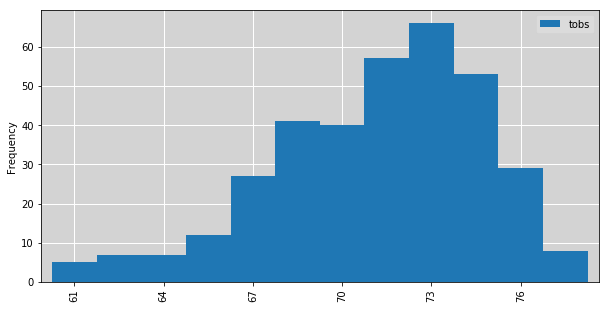

In [14]:
#Plot the results as a histogram with bins=12.

df_tobs = pd.DataFrame(v_result.all(), columns=['station', 'date', 'tobs'])
max_tobs= int(df_tobs['tobs'].max())
min_tobs= int(df_tobs['tobs'].min())
v_interval = int(max_tobs - min_tobs)/12

df_tobs['tobs_category'] = [min_tobs + v_interval if r['tobs'] < min_tobs + v_interval else 
                            min_tobs + 2*v_interval if r['tobs'] < min_tobs + 2*v_interval  else   
                            min_tobs + 3*v_interval if r['tobs'] < min_tobs + 3*v_interval  else  
                            min_tobs + 4*v_interval if r['tobs'] < min_tobs + 4*v_interval   else 
                            min_tobs + 5*v_interval if r['tobs'] < min_tobs + 5*v_interval   else 
                            min_tobs + 6*v_interval if r['tobs'] < min_tobs + 6*v_interval   else 
                            min_tobs + 7*v_interval if r['tobs'] < min_tobs + 7*v_interval   else 
                            min_tobs + 8*v_interval if r['tobs'] < min_tobs + 8*v_interval   else 
                            min_tobs + 9*v_interval if r['tobs'] < min_tobs + 9*v_interval   else 
                            min_tobs + 10*v_interval if r['tobs'] < min_tobs + 10*v_interval   else 
                            min_tobs + 11*v_interval if r['tobs'] < min_tobs + 11*v_interval   else 
                            max_tobs 
                            for i,r in df_tobs.iterrows()]

agg_dict_x = { 'date': ['count' ] }
df_group_type = df_tobs.groupby(['tobs_category'])
df_tobs_frequency = df_group_type.agg(agg_dict_x)
df_tobs_frequency.columns = ["_".join(x) for x in df_tobs_frequency.columns.ravel()]

df_tobs_frequency.reset_index(inplace=True)
df_tobs_frequency.rename(columns={'date_count' : 'frequency' },inplace=True)
df_tobs_frequency = df_tobs_frequency.sort_values(['tobs_category'])


#Ploting 
ax = df_tobs_frequency.plot(kind="bar", x = 'tobs_category' , y = 'frequency' ,width =1 , figsize=(10,5))
plt.ylabel("Frequency")
plt.xlabel("")
max_tobs_cat= int(df_tobs_frequency['tobs_category'].max())
min_tobs_cat= int(df_tobs_frequency['tobs_category'].min())
v_interval = int ( (max_tobs_cat - min_tobs_cat)/6)
v_loc_value_list = [x for x in range(min_tobs_cat,max_tobs_cat,v_interval) ]
v_loc_list = [x for x in range(1,6,v_interval) ]

plt.xticks(v_loc_list, v_loc_value_list)
ax.set_facecolor('lightgray')
ax.xaxis.grid(color='white', linestyle='solid', linewidth=1)
ax.yaxis.grid(color='white', linestyle='solid', linewidth=1)
ax.set_axisbelow(True) # show plots on top of grid lines
ax.set_xticks(np.arange(0,12, 2)  )
plt.legend(['tobs'], fancybox=True,facecolor  = 'inherit', framealpha=.2)
plt.show()

In [12]:
# Temperature Analysis
# Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d and return the minimum, average, and maximum temperatures for that range of dates.

def calc_temps(v_start_date_str  ,v_end_date_str  ):
    '''
    This will accept a start date and end date in the format %Y-%m-%d and return the minimum, average, 
    and maximum temperatures for that range of dates.
    '''
    sel = [func.min(c_measurement.tobs), 
       func.avg(c_measurement.tobs),
      func.max(c_measurement.tobs)]

    v_result = sess.query(*sel).filter(c_measurement.date <= v_end_date_str).filter(c_measurement.date >= v_start_date_str).first()
    v_min_temp = v_result[0]
    v_avg_temp = v_result[1]
    v_max_temp = v_result[2]
    v_result_list = [v_min_temp,v_avg_temp,v_max_temp]
    return v_result_list

# Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")
#since data is older--using below as vacation dates (Picked 2017)
planned_vacation_start_date_str = '2017-07-07'
planned_vacation_end_date_str = '2017-08-01'

history_vacation_start_date_str = str(int(planned_vacation_start_date_str.split("-")[0]) -1) +'-'+ planned_vacation_start_date_str.split("-")[1] +'-'+  planned_vacation_start_date_str.split("-")[2]
history_vacation_end_date_str = str(int(planned_vacation_end_date_str.split("-")[0]) -1) +'-'+ planned_vacation_end_date_str.split("-")[1] +'-'+  planned_vacation_end_date_str.split("-")[2]
vacation_station = max([r['station'] for i,r in df_station.iterrows()  if 'HONOLULU'.lower() in r['name'].lower()  ])

v_result_temp_analysis = calc_temps (history_vacation_start_date_str, history_vacation_end_date_str)

print(v_result_temp_analysis)



[Decimal('71.0000'), 77.43971631205673, Decimal('83.0000')]


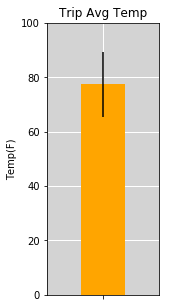

In [13]:
# Plot the min, avg, and max temperature from your previous query as a bar chart.

# Use the average temperature as the bar height.
list_of_y = v_result_temp_analysis[1]
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).
#list_of_standard_errors
list_of_standard_errors =  int (v_result_temp_analysis[2] -  v_result_temp_analysis[0])
#Ploting 
fig, ax = plt.subplots(figsize=(2, 5))
ax.bar('', list_of_y, yerr=list_of_standard_errors,facecolor='orange' )
plt.ylabel("Temp(F)")
plt.xlim(-1, 1)
plt.ylim(0, 100)
plt.title("Trip Avg Temp",fontsize=12)
ax.set_facecolor('lightgray')
ax.xaxis.grid(color='white', linestyle='solid', linewidth=1)
ax.yaxis.grid(color='white', linestyle='solid', linewidth=1)
ax.set_axisbelow(True) # show plots on top of grid lines

plt.show()